In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import os

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pre_fun import *

import matplotlib.ticker as ticker
matplotlib.rcParams['text.usetex'] = False
# matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
def loader( number ):

    sol_list = []
    cur_list = []
    cur_ss_arr = np.zeros( [number,2], dtype = np.float64)
    label_list = []
    total_concentration = np.zeros( number, dtype = np.float64 )
    volt_arr = np.zeros( number, dtype = np.float64)
    
    for i in range(0,number):

        name = '20180604_test_Dt_' +  str(i) + '_model_1_k3.sim'

        stp = Setup.load_setup( name )

        # extract steady state solution
        sol_list.append( stp.sol_data[:,-1])

        # extract current
        cur_list.append( stp.current_data )

        # extract steady state current
        cur_ss_arr[i,:] = stp.current_ss 

        # extract voltage
        volt_arr[i] = np.mean(stp.input_voltage_data) * stp.phi0 * 1e3 

        # extract label
        label_list.append(r'$\phi_C = {:1.1f} $ mV'.format(np.mean(stp.input_voltage_data) * stp.phi0 * 1e3))
        
        # extract total_concentration
        Dx, centers = stp.calcAxis()
        total_concentration[i] = np.dot(stp.sol_data[0:stp.I,-1], Dx) 
        
        print("Setup " + str(i) + " loaded")
        
    return sol_list, cur_list, cur_ss_arr, label_list, total_concentration, volt_arr

# load setup objects or data
sol_list, cur_list, cur_ss_arr, label_list, total_concentration, volt_arr =  loader( 16 )

Setup 0 loaded
Setup 1 loaded
Setup 2 loaded
Setup 3 loaded
Setup 4 loaded
Setup 5 loaded
Setup 6 loaded
Setup 7 loaded
Setup 8 loaded
Setup 9 loaded
Setup 10 loaded
Setup 11 loaded
Setup 12 loaded
Setup 13 loaded
Setup 14 loaded
Setup 15 loaded


In [4]:
# create reference setup obj
stp = Setup(  I = 500,
                    N = 60000,
                    Dt = 1e-3,
                    T = 300,
                    L = 10,
                    lengthscale = 1e9,
                    c0_in = 1.0,
                    DA = 1.0,
                    DC = 1.0,
                    D0_in = 1e-10,
                    epsilon = 1.0,
                    epsilon_m = 80.0,
                    testname = 'reference',
                    model = 1,
                   sim_method = "single_const",
                   kA = 1e-1,
                   kC = 1e-1,
                   foxA = 0.5e-1,
                       foxC = 0.5e-1, 
                    steady_state_tol = 1e-8,)


In [5]:
# save vergleichsarrays
np.save('cur_ss_3.npy', cur_ss_arr)
np.save('tot_c_3.npy', total_concentration)

In [ ]:
_, centers = stp.calcAxis()

I = stp.I

# reference entities
L = stp.L

# plot steady state solutions
fig = plt.figure( dpi = 120 )
    
# create axes
ax = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2, sharex = ax)


# find list minimum and maximum values
cmin_tmp = min([ el[0:2*I].min() for el in sol_plot ])
cmax_tmp = max([ el[0:2*I].max() for el in sol_plot ])

pmin_tmp = min([ el[2*I:3*I].min() for el in sol_plot ])
pmax_tmp = max([ el[2*I:3*I].max() for el in sol_plot ])

# extraxt ion/pot max and min on yaxis and xaxis
cmin = cmin_tmp - cmin_tmp * 0.05
cmax = cmax_tmp +  cmax_tmp * 0.05

phimin = pmin_tmp - pmin_tmp * 0.05
phimax = pmax_tmp + pmax_tmp * 0.05
        
# iterate over sol_plot list
for i in range(0, sol_list.__len__() ):

    # cations
    c_line = ax.plot(centers * L, sol_list[i][0:I], color = "blue", alpha = 0.7, lw = 1.4,)[0];

    # anions
    a_line = ax.plot(centers * L, sol_list[i][I:2*I], color = "red",alpha = 0.7, lw = 1.4,)[0];

    # potential
    p_line = ax1.plot(centers * L, sol_list[i][2*I:3*I],alpha = 0.7, color = "black", lw = 1.4,)[0];

# labels
ax.set_ylabel(r"Concentration [M]")
ax1.set_xlabel(r"x [nm]")
ax1.set_ylabel(r"Potential [mV]")

# grids
ax.grid(b=True, which = 'major', axis = 'both')
ax1.grid(b=True, which = 'major', axis = 'both')

# axis ticks
plt.setp(ax.get_xticklabels(), visible = False)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))

ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = 8)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# fill anode catode
ax.fill_between( [xmin,0],cmin, cmax, facecolor = "red", alpha = 0.4)
ax1.fill_between( [xmin,0],phimin, phimax, facecolor = "red", alpha = 0.4)

ax.fill_between( [L,xmax+1],cmin, cmax, facecolor = "blue", alpha = 0.4)
ax1.fill_between( [L,xmax+1],phimin, phimax, facecolor = "blue", alpha = 0.4)

# annotate anode catode
ax.text(0.005, 0.56, 'Anode', rotation=90,transform=ax.transAxes, fontsize = 8)
ax1.text(0.005, 0.56, 'Anode', rotation=90,transform=ax1.transAxes, fontsize = 8)

ax.text(0.975, 0.56, 'Catode', rotation=90,transform=ax.transAxes, fontsize = 8)
ax1.text(0.975, 0.56, 'Catode', rotation=90,transform=ax1.transAxes, fontsize = 8)

# set ax limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([cmin, cmax])
ax1.set_ylim([phimin, phimax])

plt.show()

In [ ]:
# sol = setup_list[0].sol_data
current = setup_list[0].current_data
setup_list[0].__dict__

-39.371642640583026
-0.022135444563740954
Line2D(_line0)
Line2D(_line1)
Line2D(_line2)
Line2D(_line3)
Line2D(_line4)
Line2D(_line5)
Line2D(_line6)
Line2D(_line7)


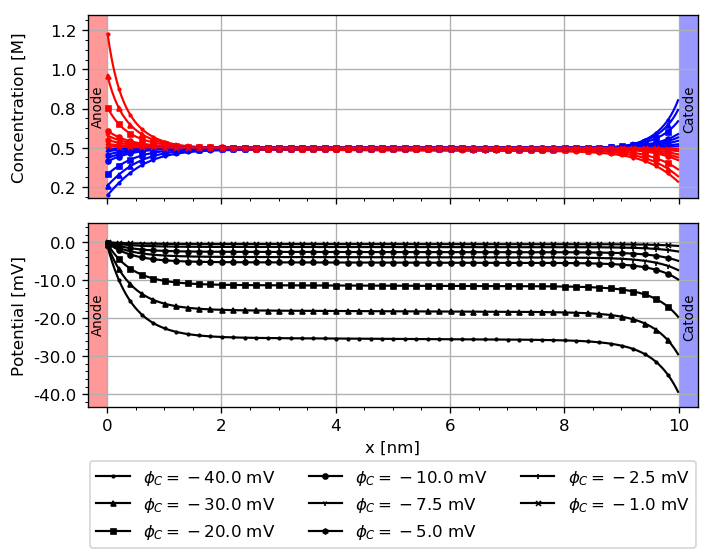

In [8]:
# Define plotting functions

def interactivePlotting( I, sol_arg, centers, L, plotindex = None, markers = None,
                        styles = None, labels = None, savename = None ):
    """
    Plotting time dependent solutions
    """
    label_flag = 0
    marker_flag = 0
    style_flag = 0
    
    # check input
    if isinstance( sol_arg, np.ndarray):
        # normal or interactive plot mode
        
        if plotindex is None and not sol_arg.shape.__len__() == 1:
            
            raise ValueError('Dimension mismatch, have to give plotindex')
        
        elif sol_arg.shape.__len__() == 1:
            
            sol_plot = [ sol_arg ]
            
            # extraxt ion/pot max and min on yaxis and xaxis
            cmin = sol_arg[0:2*I].min() - sol_arg[0:2*I].min() * 0.05
            cmax = sol_arg[0:2*I].max() + sol_arg[0:2*I].max() * 0.05

            phimin = sol_arg[2*I:3*I].min() - sol_arg[2*I:3*I].min() * 0.05
            phimax = sol_arg[2*I:3*I].max() + sol_arg[2*I:3*I].max() * 0.05
        
        elif isinstance(plotindex, int) and sol_arg.shape.__len__() == 2:
            
            sol_plot = [ sol_arg[:,plotindex] ]
            
            # extraxt ion/pot max and min on yaxis and xaxis
            cmin = sol_arg[0:2*I,:].min() - sol_arg[0:2*I,:].min() * 0.05
            cmax = sol_arg[0:2*I,:].max() + sol_arg[0:2*I,:].max() * 0.05

            phimin = sol_arg[2*I:3*I,:].min() - sol_arg[2*I:3*I,:].min() * 0.05
            phimax = sol_arg[2*I:3*I,:].max() + sol_arg[2*I:3*I,:].max() * 0.05
            
    elif isinstance( sol_arg, list):
        # plot single sol pictures

        sol_plot = sol_arg
        
        cmin_tmp = min([ el[0:2*I].min() for el in sol_plot ])
        cmax_tmp = max([ el[0:2*I].max() for el in sol_plot ])
        
        pmin_tmp = min([ el[2*I:3*I].min() for el in sol_plot ])
        pmax_tmp = max([ el[2*I:3*I].max() for el in sol_plot ])
        
        print(pmin_tmp)
        print(pmax_tmp)
        # extraxt ion/pot max and min on yaxis and xaxis
        cmin = cmin_tmp - np.abs(cmin_tmp) * 0.1
        cmax = cmax_tmp +  np.abs(cmax_tmp) * 0.1
        
        # deal with small minimum / maximum
        if np.abs(pmin_tmp) < 1 :
            
            phimin = -5 # mV
            
        else:
            
             phimin = pmin_tmp - np.abs(pmin_tmp) * 0.1
            
        if  np.abs(pmax_tmp) < 1 :
                       
            phimax = 5 # mV
            
        else:
            
            phimax = pmax_tmp + np.abs(pmax_tmp) * 0.1
        
    if not markers is None:
    
        if not isinstance(markers, list) or not markers.__len__() == sol_plot.__len__():
            
            raise ValueError('Markers have to be a list with same length as sol_arg!')
            
        else:
            
            marker_flag = 1
    
    if not styles is None:
        
        if not isinstance(styles, list) or not styles.__len__() == sol_plot.__len__():
            
            raise ValueError('Styles have to be a list with same length as sol_arg!')
            
        else:
            
            style_flag = 1
            
    if not labels is None:
        
        if not isinstance(labels, list) and not labels.__len__() == sol_plot.__len__():
            
            raise TypeError('Labels have to be a list with same length as sol_arg!')
        
        else:
            
            label_flag = 1
            
    xmin = - L/30.
    xmax = L + L/30.
    
    fig = plt.figure( dpi = 120 )
    
    # create axes
    ax = fig.add_subplot(2,1,1)
    ax1 = fig.add_subplot(2,1,2, sharex = ax)
    
    # iterate over sol_plot list
    for i in range(0, sol_plot.__len__() ):
        
        # cations
        c_line = ax.plot(centers * L, sol_plot[i][0:I], color = "blue", alpha = 1.0, lw = 1.3,)[0];
        
        # anions
        a_line = ax.plot(centers * L, sol_plot[i][I:2*I], color = "red",alpha = 1.0, lw = 1.3,)[0];
        
        # potential
        p_line = ax1.plot(centers * L, sol_plot[i][2*I:3*I],alpha = 1.0, color = "black", lw = 1.3,)[0];
        
        print(p_line)
        
        if marker_flag == 1:
            
            c_line.set_marker(markers[i])
            c_line.set_markersize(3)
            c_line.set_markevery(10)
            
            a_line.set_marker(markers[i])
            a_line.set_markersize(3)
            a_line.set_markevery(10)
            
            p_line.set_marker(markers[i])
            p_line.set_markersize(3)
            p_line.set_markevery(10)
            
        if style_flag == 1:
            
            c_line.set_linestyle(styles[i])
            a_line.set_linestyle(styles[i])
            p_line.set_linestyle(styles[i])
            
        if label_flag == 1:
            
           # c_line.set_label(labels[i])
            #a_line.set_label(labels[i])
            p_line.set_label(labels[i])
            
    # axis spec 
    
    # labels
    ax.set_ylabel(r"Concentration [M]")
    ax1.set_xlabel(r"x [nm]")
    ax1.set_ylabel(r"Potential [mV]")
    
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax1.yaxis.set_label_coords(-0.1, 0.5)
    
    # grids
    ax.grid(b=True, which = 'major', axis = 'both', linewidth = 0.8)
    ax1.grid(b=True, which = 'major', axis = 'both', linewidth = 0.8)
    
    # axis ticks
    plt.setp(ax.get_xticklabels(), visible = False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))
    
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)
#     ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = 8)
    
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # fill anode catode
    ax.fill_between( [xmin,0],cmin, cmax, facecolor = "red", alpha = 0.4)
    ax1.fill_between( [xmin,0],phimin, phimax, facecolor = "red", alpha = 0.4)
    
    ax.fill_between( [L,xmax+1],cmin, cmax, facecolor = "blue", alpha = 0.4)
    ax1.fill_between( [L,xmax+1],phimin, phimax, facecolor = "blue", alpha = 0.4)
    
    # annotate anode catode
    ax.text(0.005, 0.56, 'Anode', rotation=90,transform=ax.transAxes, fontsize = 8)
    ax1.text(0.005, 0.56, 'Anode', rotation=90,transform=ax1.transAxes, fontsize = 8)
    
    ax.text(0.975, 0.56, 'Catode', rotation=90,transform=ax.transAxes, fontsize = 8)
    ax1.text(0.975, 0.56, 'Catode', rotation=90,transform=ax1.transAxes, fontsize = 8)
    
    # set ax limits
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([cmin, cmax])
    ax1.set_ylim([phimin, phimax])
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    handles1, labels1 = ax1.get_legend_handles_labels()
    
    if label_flag == 1:
        
        ax1.legend(handles + handles1, labels + labels1, loc = 9, bbox_to_anchor = (0.5,-0.25), fancybox = True, ncol = 3 )
    
    fig.tight_layout()
    
    if isinstance(savename, str):
        
        for fmt in ['png', 'pdf']:
            fig.savefig(savename + '.' + fmt, dpi = 300, format = fmt, bbox_inches = 'tight' )
    
    plt.show()
    
def i_plot( sol, plotindex, I, centers ):
    
    ymin = sol[0:2*I,:].min() - 0.05 * sol[0:2*I,:].min()
    ymax = sol[0:2*I,:].max() + 0.05 * sol[0:2*I,:].max()
    
    fig = plt.figure( dpi = 120 )
    ax = fig.add_subplot(1,1,1)
    ax1 = ax.twinx()
    
    ax.plot( centers, sol[0:I,plotindex], color = "blue")
    ax.plot( centers, sol[I:2*I,plotindex], color = "red")
    ax1.plot( centers, sol[2*I:3*I,plotindex], color = "black")
    
    ax.set_ylim([ymin, ymax])
    
    plt.show()
    
# plot solution

# _, centers = setup_list[0].calcAxis()

# interact( i_plot,
#          sol = fixed(sol),
#          plotindex =widgets.IntSlider(min = 0, max = setup_list[0].N-1, value = 0),
#          I = fixed(setup_list[0].I),
#          centers = fixed(centers),
#           );

_, centers = stp.calcAxis()

L = stp.L
markers = ['.','^','s', 'o','1','h','+','x']#,'*',]#'D'  ]
# styles = [':', '--', '-','--','-', '--', '-',':','-','--' ]
# labels = [5e-3, 10e-3, 15e-3, 20e-3, 30e-3 ]
# labels = ['$\phi_C = -30e-3$ mV',
#           '$\phi_C = -20e-3$ mV',
#           '$\phi_C = -15e-3$ mV',
#           '$\phi_C = -10e-3$ mV' ,
#           '$\phi_C = -5e-3$ mV',
#           '$\phi_C = 5e-3$ mV',
#           '$\phi_C = 10e-3$ mV',
#           '$\phi_C = 15e-3$ mV',
#           '$\phi_C = 20e-3$ mV',
#           '$\phi_C = 30e-3$ mV' ]
   

interactivePlotting( stp.I, sol_list[:8], centers, L, plotindex = None, 
                    markers = markers[:],
#                     styles = styles[5:],
                     labels = label_list[:8],
                    savename = "20180605_model_1_sweep_low_3"
                   );

(11367,)
11367
(10749,)
10749
(9975,)
9975
(8763,)
8763
(8277,)
8277
(7598,)
7598
(6446,)
6446
(4929,)
4929
(4929,)
4929
(6446,)
6446
(7598,)
7598
(8277,)
8277
(8763,)
8763
(9975,)
9975
(10749,)
10749
(11367,)
11367


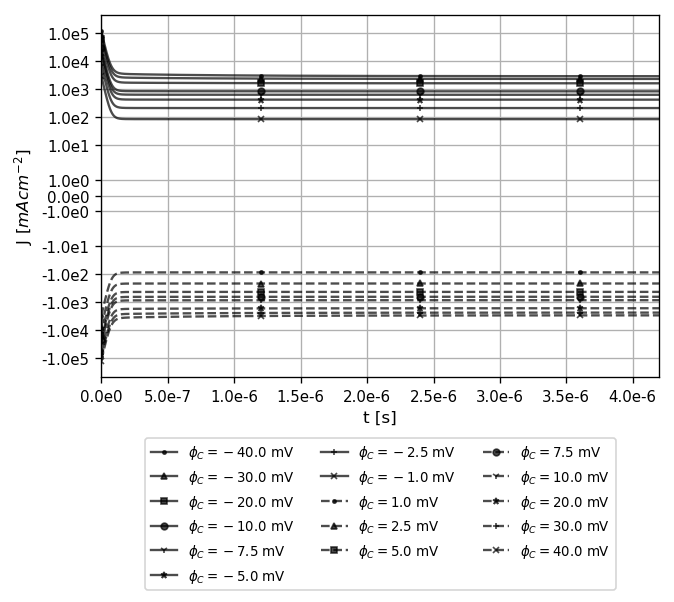

In [14]:
# plot current function
# plot current
def plotCurrent( Dt, T0, cur_arg, electrode = 'anode', markers = None, styles = None, labels = None,
               savename = None):
    
    # cur arg is list or cur arg is single numpy array
    label_flag = 0
    marker_flag = 0
    style_flag = 0
    
    # check input
    if isinstance( cur_arg, np.ndarray):

        # normal or interactive plot mode
        if electrode == 'anode':
            
            cur_plot = [ cur_arg[0,3:] ]
            
            plotcolor = 'red'
            
        elif electrode == 'catode':
            
            cur_plot = [ cur_arg[1,3:] ]
            
        elif electrode == 'both':
            
            cur_plot = [ cur_arg[:,3:] ]
            
            plotcolor = 'blue'
            
    elif isinstance( cur_arg, list):
        
        if electrode == 'anode':
            
            cur_plot = []
            
            for array in cur_arg:
                
                cur_plot.append( array[0,3:] )
            
        elif electrode == 'catode':
            
            cur_plot = []
            
            for array in cur_arg:
                
                cur_plot.append( array[1,3:] )
            
        elif electrode == 'both':
            
            cur_plot = []
            
            for array in cur_arg:
                
                cur_plot.append( array[:,3:] )
        
    if not markers is None:
    
        if not isinstance(markers, list) or not markers.__len__() == cur_plot.__len__():
            
            raise ValueError('Markers have to be a list with same length as sol_arg!')
            
        else:
            
            marker_flag = 1
    
    if not styles is None:
        
        if not isinstance(styles, list) or not styles.__len__() == cur_plot.__len__():
            
            raise ValueError('Styles have to be a list with same length as sol_arg!')
            
        else:
            
            style_flag = 1
            
    if not labels is None:
        
        if not isinstance(labels, list) and not labels.__len__() == cur_plot.__len__():
            
            raise TypeError('Labels have to be a list with same length as sol_arg!')
        
        else:
            
            label_flag = 1
            

    
    fig = plt.figure( dpi = 120 )
    
    # create axes
    ax = fig.add_subplot(1,1,1)
    
    # iterate over sol_plot list
    for i in range(0, cur_plot.__len__() ):
        
        array = cur_plot[i]
        
        print(array.shape)
        
        if electrode == 'both':
            
            N = array.shape[1]
            
            
            # create t axis
            t = np.zeros(N, dtype = np.float64)
            for j in range(0,N):
                t[j] = j*Dt        
            a_line = ax.plot(t*T0, array[0,:], color = 'red',alpha = 0.7,  lw = 1.4, )[0]
            
            c_line = ax.plot(t*T0, array[1,:], color = 'blue',alpha = 0.7,  lw = 1.4, )[0]
            
            
        else:
            
            N = array.shape[0]
            print(N)
            # create t axis
            
            t = np.zeros(N, dtype = np.float64)
            for j in range(0,N):
                t[j] = j*Dt
                
            a_line = ax.plot(t*T0, array, alpha = 0.7, color = "black", lw = 1.4, )[0]
            
        if marker_flag == 1:
            
            a_line.set_marker(markers[i])
            a_line.set_markersize(4)
            a_line.set_markevery(1200)
            
            try:
                c_line.set_marker(markers[i])
                c_line.set_markersize(3)
                c_line.set_markevery(1200)
            
            except:
                
                pass
            
        if style_flag == 1:
            
            a_line.set_linestyle(styles[i])
            
            try:
                c_line.set_linestyle(styles[i])
            except:
                pass
            
        if label_flag == 1:
            
            a_line.set_label(labels[i])
    
    # logscale
    ax.set_yscale('symlog', linthresh = 1e-12)
    
    # labels
    ax.set_ylabel(r"J [$ mA cm^{-2}$]")
    ax.set_xlabel(r"t [s]")
    
    # grids
    ax.grid(b=True, which = 'major', axis = 'both')
        
    # axis ticks
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1e"))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1e"))
    
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)
       
#     ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
#     ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlim([0,4.2e-6])
    if label_flag == 1:
        
        handles, labels = ax.get_legend_handles_labels()
        
        ax.legend(handles, labels, loc = 9, bbox_to_anchor = (0.5,-0.15), fancybox = True, ncol = 3, fontsize = 8 )
                   # bbox_to_anchor = (0.55,-0.15), fancybox = True,  )
    
    
    
    plt.draw()
    
    # get ticklabels
    ty = ax.get_yticklabels()
    tx = ax.get_xticklabels()
    
    # modify ticklabel: remove annoying +0 in exponent
    for el in ty:
        ylab = el.get_text().split(sep = 'e')[0] + 'e' + el.get_text().split(sep = 'e')[1].replace('+0','').replace('-0','-')
        el.set_text(ylab)
        
    for el in tx:
        
        if not el.get_text() == '':
            xlab = el.get_text().split(sep = 'e')[0] + 'e' + el.get_text().split(sep = 'e')[1].replace('+0','').replace('-0','-')
            el.set_text(xlab)
    
    # set ticklabels
    ax.set_yticklabels(ty, fontsize = 9)
    ax.set_xticklabels(tx, fontsize = 9)
    
    plt.draw()
    
    
    if isinstance(savename, str):

        for fmt in ['png', 'pdf']:
           
            fig.savefig(savename + '.' + fmt, dpi = 300, format = fmt, bbox_inches = 'tight' )
     
#-----------------end function--------------------------------------------------------------
    
markers = ['.','^','s', 'o','1','*','+','x' ] + ['.','^','s', 'o','1','*','+','x' ]   #,'*']#,'D'  ]
styles = ['-', '-', '-','-','-', '-', '-','-'] + ['--', '--', '--','--','--', '--', '--','--']#,'-','--' ]

plotCurrent( stp.Dt, stp.T0, cur_list[:], electrode = 'anode',
           markers = markers[:],
            styles = styles[:],
           labels = label_list[:],
            savename = "20180605_model_1__anode_3_complete"
           )

In [21]:
# load old solutions

cur_ss_arr1 = np.load('cur_ss_1.npy')
cur_ss_arr2 = np.load('cur_ss_2.npy')
total_concentration1 = np.load('tot_c_1.npy')
total_concentration2 = np.load('tot_c_2.npy')

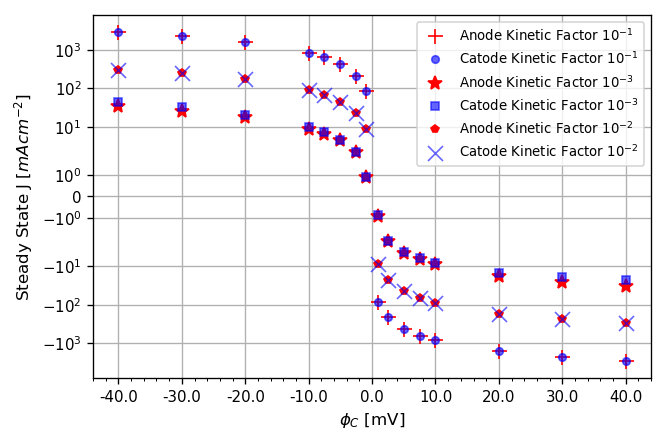

In [35]:


# plot steady state currents       
fig = plt.figure( dpi = 120 )
    
# create axes
ax = fig.add_subplot(1,1,1)

ax.plot(volt_arr, cur_ss_arr[:,0], ls = 'None', marker = '+', markersize = 9,
        color = 'red', label = 'Anode Kinetic Factor $10^{-1}$')

ax.plot(volt_arr, cur_ss_arr[:,1], ls = 'None', marker = '.', markersize = 9,
        color = 'blue', label = 'Catode Kinetic Factor $10^{-1}$', alpha = 0.6)

ax.plot(volt_arr, cur_ss_arr1[:,0], ls = 'None', marker = '*', markersize = 9,
        color = 'red', label = 'Anode Kinetic Factor $10^{-3}$')

ax.plot(volt_arr, cur_ss_arr1[:,1], ls = 'None', marker = 's', markersize = 5,
        color = 'blue', label = 'Catode Kinetic Factor $10^{-3}$', alpha = 0.6)

ax.plot(volt_arr, cur_ss_arr2[:,0], ls = 'None', marker = 'p', markersize = 5,
        color = 'red', label = 'Anode Kinetic Factor $10^{-2}$')

ax.plot(volt_arr, cur_ss_arr2[:,1], ls = 'None', marker = 'x', markersize = 9,
        color = 'blue', label = 'Catode Kinetic Factor $10^{-2}$', alpha = 0.6)

# labels
ax.set_ylabel(r"Steady State J [$mA cm^{-2}$]")
ax.set_xlabel(r"$\phi_C$ [mV]")

# grids
ax.grid(b=True, which = 'major', axis = 'both', lw = 0.8)

# axis ticks
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))

#ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize = 8 )

ax.set_yscale('symlog', linthresh = 1e-14)

plt.draw()

# get ticklabels
ty = ax.get_yticklabels()
tx = ax.get_xticklabels()

# modify ticklabel: remove annoying +0 in exponent
# for el in ty:
    
#     print(el.get_text())#.split(sep = 'e'))
#     ylab = el.get_text().split(sep = 'e')[0] + 'e' + el.get_text().split(sep = 'e')[1].replace('+0','').replace('-0','-')
#     el.set_text(ylab)

# set ticklabels
ax.set_yticklabels(ty, fontsize = 9)
ax.set_xticklabels(tx, fontsize = 9)


plt.show()


for fmt in ['png', 'pdf']:
    fig.savefig('20180605_model1_test_UI_compl_log' + '.' + fmt, dpi = 300, format = fmt, bbox_inches = 'tight' )

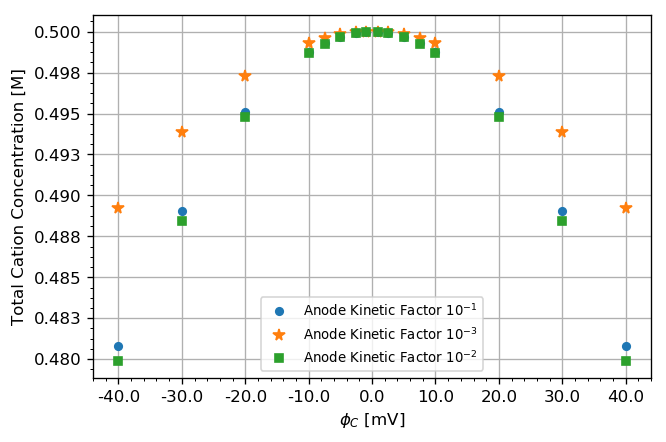

In [41]:
# plot total concentration against voltage

fig = plt.figure( dpi = 120 )

ax = fig.add_subplot(1,1,1)

ax.plot(volt_arr, total_concentration, ls = 'None', marker = '.', markersize = 9,label = 'Anode Kinetic Factor $10^{-1}$')
ax.plot(volt_arr, total_concentration1, ls = 'None', marker = '*', markersize = 7, label = 'Anode Kinetic Factor $10^{-3}$')
ax.plot(volt_arr, total_concentration2, ls = 'None', marker = 's', markersize = 5, label = 'Anode Kinetic Factor $10^{-2}$' )

# labels
ax.set_ylabel(r"Total Cation Concentration [M]")
ax.set_xlabel(r"$\phi_C$ [mV]")

# grids
ax.grid(b=True, which = 'major', axis = 'both', lw = 0.8)

# axis ticks
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1.3f"))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%1.1f"))

#ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize = 8 )

plt.show()

for fmt in ['png', 'pdf']:
    fig.savefig('20180605_model1_total_C_conc_total' + '.' + fmt, dpi = 300, format = fmt, bbox_inches = 'tight' )
